In [8]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Import of full_df 



In [9]:
full_df = pd.read_pickle('../data/processed/full_df.pkl')
full_df

,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,actual_block_time,flt_event_number,rot_mismatch,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,Crewchange,rows_to_drop,rows_to_drop_grounddelay
0,272024970,East Carmen Airlines,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,320,0,0,95.0,94.0,2019-06-01,321,EC3292,ECLBAX,45.0,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,191.0,1,False,-9.0,25.0,5,3,6,both,0,0
1,272022230,East Carmen Airlines,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,320,60,60,75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,126.0,2,False,-9.0,15.0,5,8,10,no change,0,0
2,272212848,East Carmen Airlines,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,320,68,75,80.0,86.0,2019-06-01,321,EC3258,ECLBAX,45.0,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,131.0,3,False,-14.0,51.0,5,11,14,both,0,0
3,271997824,East Carmen Airlines,EC3021,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,320,64,70,50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,74.0,4,False,-11.0,43.0,5,15,17,no change,0,0
4,271998033,East Carmen Airlines,EC3022,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,320,42,50,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,70.0,5,False,-10.0,14.0,5,17,19,last flt of day,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12096,272211046,East Carmen Airlines,EC3234,Lisamouth,East Carmen,2019-06-30,2019-06-30 10:30:00,2019-06-30,2019-06-30 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,50.0,85.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,91.0,3,False,-9.0,4.0,6,10,12,both,0,0
12097,271969272,East Carmen Airlines,EC2687,East Carmen,West Jason,2019-06-30,2019-06-30 13:00:00,2019-06-30,2019-06-30 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,45.0,54.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,66.0,4,False,-9.0,30.0,6,13,14,no change,0,0
12098,271969452,East Carmen Airlines,EC2688,West Jason,East Carmen,2019-06-30,2019-06-30 15:00:00,2019-06-30,2019-06-30 16:20:00,2019-06-30 15:30:00,2019-06-30 16:40:00,ECLXEX,rotational problem,30.0,320,41,45,45.0,57.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,70.0,5,False,-10.0,30.0,6,15,16,no change,0,0
12099,272187492,East Carmen Airlines,EC2693,East Carmen,West Jason,2019-06-30,2019-06-30 17:05:00,2019-06-30,2019-06-30 18:20:00,2019-06-30 17:37:00,2019-06-30 19:01:00,ECLXEX,rotational proble

<AxesSubplot:>

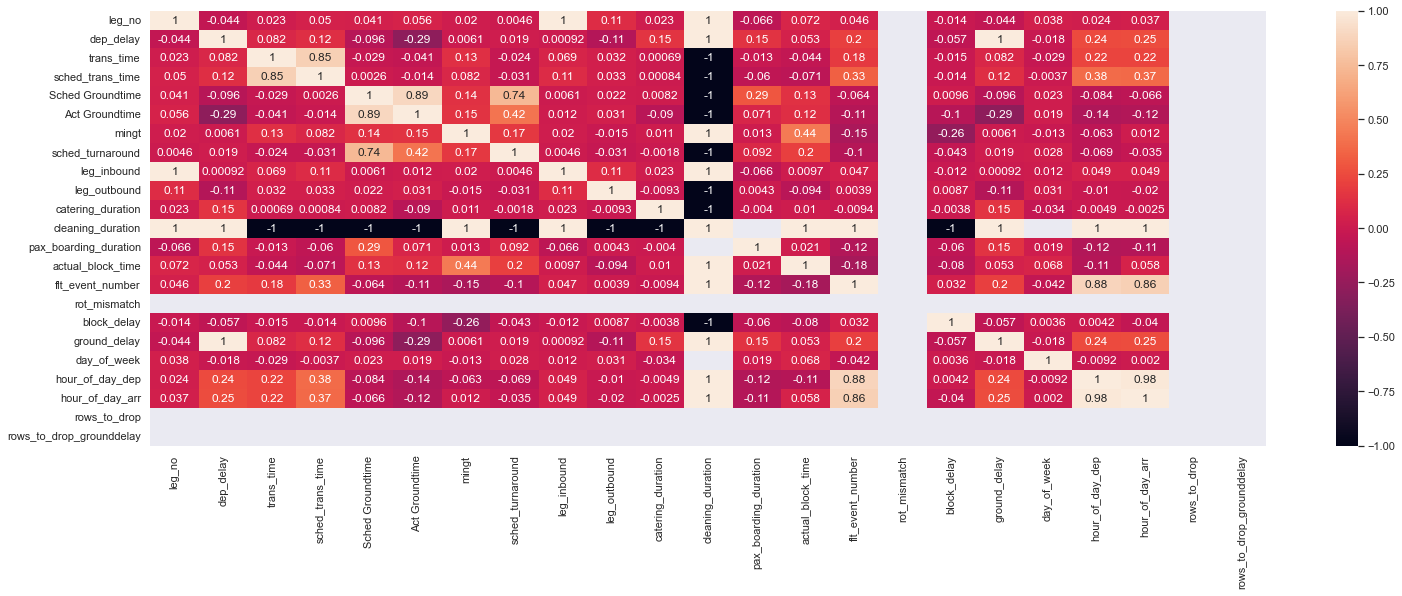

In [10]:
# Correlation Matrix
sns.set(rc={'figure.figsize':(25, 8)})
corr_ground = full_df[full_df['rows_to_drop_grounddelay']==0].corr()
sns.heatmap(corr_ground, annot=True)

In [11]:
full_df[full_df['sched_turnaround'] != full_df['Sched Groundtime']].dropna( subset = ['Sched Groundtime', 'sched_turnaround'])

,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,actual_block_time,flt_event_number,rot_mismatch,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,Crewchange,rows_to_drop,rows_to_drop_grounddelay
2663,272015977,East Carmen Airlines,EC3220,Erichaven,East Carmen,2019-06-08,2019-06-08 10:30:00,2019-06-08,2019-06-08 12:25:00,2019-06-08 10:46:00,2019-06-08 12:26:00,ECLBSX,other problem,16.0,320,11,45,360.0,378.0,2019-06-08,320,EC3220,ECLBSX,40.0,Erichaven,East Carmen,NaN,2019-06-08 10:30:00,2019-06-08 12:25:00,2019-06-08 13:15:00,2019-06-08 14:00:00,50.0,272015977.0,272352651.0,28.0,NaN,NaN,100.0,3,False,-15.0,16.0,5,10,12,both,0,0
2850,272100521,East Carmen Airlines,EC11460,Richardsonburgh,East Carmen,2019-06-09,2019-06-09 08:15:00,2019-06-09,2019-06-09 10:55:00,2019-06-09 08:43:00,2019-06-09 11:15:00,ECLBTX,other problem,28.0,320,44,45,430.0,429.0,2019-06-09,320,EC11460,ECLBTX,40.0,Richardsonburgh,East Carmen,NaN,2019-06-09 08:15:00,2019-06-09 10:55:00,2019-06-09 12:00:00,2019-06-09 12:45:00,65.0,272100521.0,272352652.0,21.0,NaN,NaN,152.0,2,False,-8.0,28.0,6,8,10,both,0,0
5069,271961157,East Carmen Airlines,EC2614,Yoderburgh,East Carmen,2019-06-04,2019-06-04 05:00:00,2019-06-04,2019-06-04 06:35:00,2019-06-04 05:13:00,2019-06-04 06:45:00,ECLDGX,other problem,13.0,320,0,0,400.0,471.0,2019-06-04,319,EC2614,ECLDGX,40.0,Yoderburgh,East Carmen,NaN,2019-06-04 05:00:00,2019-06-04 06:35:00,2019-06-04 07:40:00,2019-06-04 08:25:00,65.0,271961157.0,272352650.0,26.0,NaN,NaN,92.0,1,False,-3.0,13.0,1,5,6,both,0,0
5558,272011137,East Carmen Airlines,EC3168,North Anna,East Carmen,2019-06-28,2019-06-28 19:20:00,2019-06-28,2019-06-28 20:10:00,2019-06-29 03:16:00,2019-06-29 03:57:00,ECLGBX,other problem,476.0,DH4,15,30,540.0,134.0,2019-06-28,DH4,EC3168,ECLGBX,35.0,North Anna,East Carmen,East Carmen,2019-06-28 19:20:00,2019-06-28 20:10:00,2019-06-28 21:15:00,2019-06-28 22:30:00,65.0,272011137.0,271984461.0,18.0,NaN,491.0,41.0,11,False,-9.0,476.0,4,19,20,last flt of day,0,1
6288,272030922,East Carmen Airlines,EC3372,Fisherhaven,East Carmen,2019-06-09,2019-06-09 06:05:00,2019-06-09,2019-06-09 07:10:00,2019-06-09 08:22:00,2019-06-09 09:27:00,ECLGIX,other problem,137.0,DH4,0,0,235.0,124.0,2019-06-09,DH4,EC3372,ECLGIX,30.0,Fisherhaven,East Carmen,East Carmen,2019-06-09 06:05:00,2019-06-09 07:10:00,2019-06-09 07:55:00,2019-06-09 08:40:00,45.0,272030922.0,272032738.0,26.0,NaN,134.0,65.0,1,False,0.0,137.0,6,6,7,both,0,0
7277,272210730,East Carmen Airlines,EC3230,Haynesside,East Carmen,2019-06-19,2019-06-19 13:05:00,2019-06-19,2019-06-19 14:20:00,2019-06-19 13:05:00,2019-06-19 14:17:00,ECLGOX,no reason,0.0,DH4,23,55,235.0,249.0,2019-06-19,DHX,EC3230,ECLGOX,35.0,Haynesside,East Carmen,East Carmen,2019-06-19 13:05:00,2019-06-19 14:20:00,2019-06-19 15:20:00,2019-06-19 16:05:00,60.0,272210730.0,272012153.0,23.0,NaN,17.0,72.0,5,False,-3.0,0.0,2,13,14,cockpit,0,0
7569,272010710,East Carmen Airlines,EC3166,North Anna,East Carmen,2019-06-09,2019-06-09 16:40:00,2019-06-09,2019-06-09 17:35:00,2019-06-09 16:43:00,2019-06-09 17:27:00,ECLGQX,other problem,3.0,DH4,35,40,-145.0,12.0,2019-06-09,DHX,EC3166,ECLGQX,35.0,North Anna,East Carmen,Port Courtneytown,2019-06-09 16:40:00,2019-06-09 17:35:00,2019-06-09 18:15:00,2019-06-09 19:00:00,40.0,272010710.0,272032377.0,18.0,NaN,0.0,44.0,7,False,-11.0,3.0,6,16,17,no change,0,0
7920,271980429,East Carmen Airlines,EC2788,Castroville,East Carmen,2019-06-06,2019-06-06 04:45:00,2019-06-06,2019-06-06 07:10:00,2019-06-06 08:04:00,2019

In [12]:
corr_ground['ground_delay'].sort_values()

Act Groundtime             -0.286627
leg_outbound               -0.112457
Sched Groundtime           -0.096017
block_delay                -0.056666
leg_no                     -0.043788
day_of_week                -0.018390
leg_inbound                 0.000925
mingt                       0.006123
sched_turnaround            0.018917
actual_block_time           0.052579
trans_time                  0.081855
sched_trans_time            0.117978
pax_boarding_duration       0.147114
catering_duration           0.148800
flt_event_number            0.196157
hour_of_day_dep             0.244628
hour_of_day_arr             0.250173
cleaning_duration           1.000000
dep_delay                   1.000000
ground_delay                1.000000
rot_mismatch                     NaN
rows_to_drop                     NaN
rows_to_drop_grounddelay         NaN
Name: ground_delay, dtype: float64

Hypothesis 4: Time of day has influence on dep delay

<AxesSubplot:xlabel='Min_of_Day', ylabel='ground_delay'>

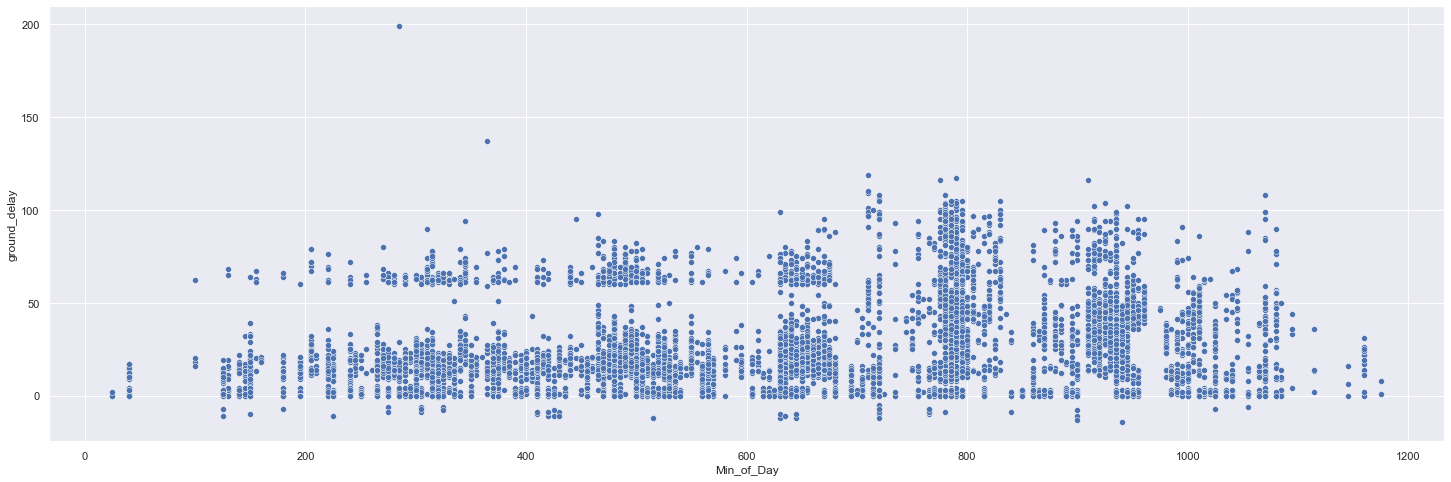

In [13]:
temp = full_df[full_df['rows_to_drop_grounddelay']==0][['dep_sched_time', 'ground_delay']]

temp['Min_of_Day'] = temp['dep_sched_time'].dt.hour*60 + temp['dep_sched_time'].dt.minute


sns.set(rc={'figure.figsize':(25, 8)})
sns.scatterplot(x=temp['Min_of_Day'], y=temp['ground_delay'])


<AxesSubplot:>

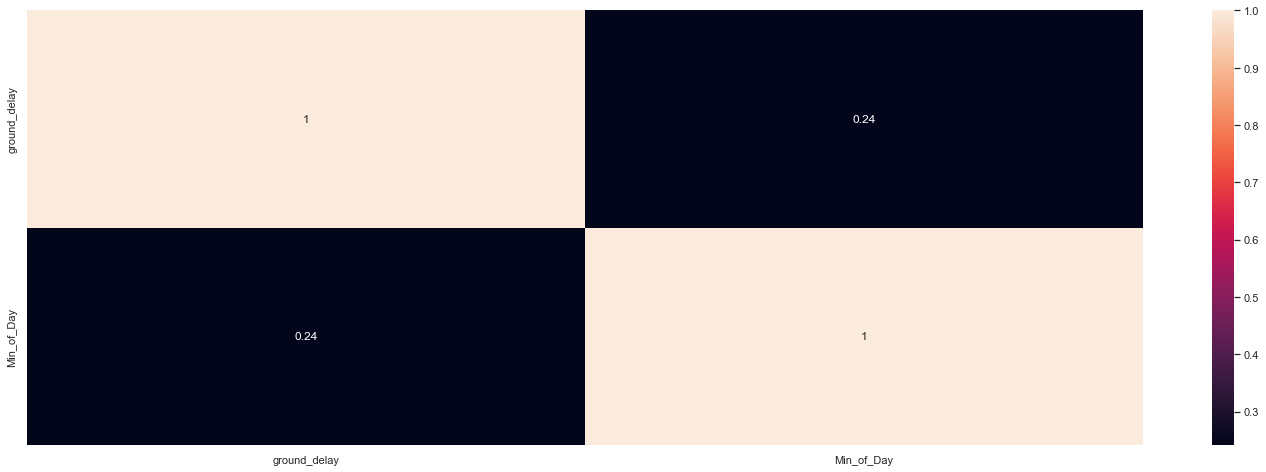

In [14]:
sns.heatmap(temp.corr(), annot = True)